In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, random_split, ChainDataset
import torch.optim as optim
import matplotlib.pyplot as plt 
import torch.nn.functional as F


In [2]:
device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv3d(1, 10, kernel_size=3)
        self.conv2 = nn.Conv3d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout3d()
        self.fc1 = nn.Linear(540, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self, x):
        x = F.relu(F.max_pool3d(self.conv1(x), 2))
        x = F.relu(F.max_pool3d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 540)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [4]:
realImages = np.load("originalSubsets.npy")
realImages.shape

(1967, 20, 20, 20)

In [5]:
fakeImages = np.load("rescaledSubsets.npy")
fakeImages.shape

(1967, 20, 20, 20)

In [6]:
import random
random.shuffle(realImages)
random.shuffle(fakeImages)

In [7]:
def addInfoToList(imageList, label, dataList):
    for image in imageList:
        dataList.append((image,label))

def getDataLoaderFromList(dataList):
    return DataLoader(dataList, shuffle=True)

In [8]:
trainData = []

trainDataSize = len(realImages) //2

addInfoToList(realImages[:trainDataSize], 0., trainData)

addInfoToList(fakeImages[:trainDataSize], 1., trainData)

print(len(trainData))

1966


In [9]:
validateData = []

validateDataSize = len(realImages) //4
validateDataSize +=trainDataSize
addInfoToList(realImages[trainDataSize: validateDataSize], 0., validateData)
addInfoToList(fakeImages[trainDataSize: validateDataSize], 1., validateData)

print(len(validateData))

982


In [10]:
testData = []

addInfoToList(realImages[validateDataSize:], 0., testData)
addInfoToList(fakeImages[validateDataSize:], 1., testData)
print(len(testData))

986


In [11]:
trainData = getDataLoaderFromList(trainData)

validateData = getDataLoaderFromList(validateData)

testData = getDataLoaderFromList(testData)

In [12]:
def getAccuracyFromModel(model, dataSet):
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for img,label in dataSet:
            img, label = img.unsqueeze(0).float().to(device), label.long().to(device)
            output = model(img)
            test_loss += F.nll_loss(output, label, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            if pred == label:
                correct+=1
        test_loss /= len(testData)
        test_losses.append(test_loss)
        model.train()
        return float(correct/len(dataSet))


In [13]:
learning_rate = 0.001
momentum = 0.5



In [14]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                      momentum=momentum)

In [15]:
epochList = []

trainLossList = []
trainAccuracyList = []
validationAccuracyList = []


prevAccuracy = None

for epoch in range(1, 50):
    train_loss = 0
    for batch_idx, (img, target) in enumerate(trainData):
        img, target = img.unsqueeze(0).float().to(device), target.long().to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = F.nll_loss(output, target)
        loss.backward()
        train_loss+=loss.item()
        optimizer.step()
    validationAccuracy = getAccuracyFromModel(model, validateData) * 100.
    trainingAccuracy = getAccuracyFromModel(model, trainData) * 100.
    
    epochList.append(epoch)
    trainLossList.append(train_loss)    
    trainAccuracyList.append(trainingAccuracy)
    validationAccuracyList.append(validationAccuracy)
    
    print("Epoch # " + str(epoch) + " Accuracy = " + str(validationAccuracy))
    if prevAccuracy is None or validationAccuracy > prevAccuracy:
        prevAccuracy = validationAccuracy
        torch.save(model, 'bestModel.pkl')





<ipython-input-3-5341c141cdcd>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/home/alex/anaconda3/envs/ml/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch # 1 Accuracy = 49.18533604887983
Epoch # 2 Accuracy = 50.61099796334012
Epoch # 3 Accuracy = 52.342158859470466
Epoch # 4 Accuracy = 50.509164969450104
Epoch # 5 Accuracy = 49.38900203665988
Epoch # 6 Accuracy = 51.01832993890021
Epoch # 7 Accuracy = 53.462321792260695
Epoch # 8 Accuracy = 51.425661914460285
Epoch # 9 Accuracy = 51.5274949083503
Epoch # 10 Accuracy = 51.5274949083503
Epoch # 11 Accuracy = 55.80448065173116
Epoch # 12 Accuracy = 56.61914460285132
Epoch # 13 Accuracy = 57.43380855397149
Epoch # 14 Accuracy = 53.76782077393075
Epoch # 15 Accuracy = 65.37678207739307
Epoch # 16 Accuracy = 54.073319755600814
Epoch # 17 Accuracy = 61.608961303462316
Epoch # 18 Accuracy = 69.75560081466395
Epoch # 19 Accuracy = 73.72708757637476
Epoch # 20 Accuracy = 75.35641547861506
Epoch # 21 Accuracy = 74.43991853360488
Epoch # 22 Accuracy = 64.86761710794298
Epoch # 23 Accuracy = 78.92057026476579
Epoch # 24 Accuracy = 79.63340122199592
Epoch # 25 Accuracy = 79.12423625254583
Epoch

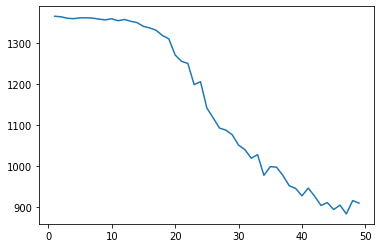

In [16]:
plt.plot(epochList, trainLossList)

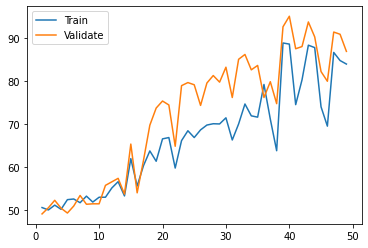

In [17]:
plt.plot(epochList, trainAccuracyList, label= "Train")
plt.plot(epochList, validationAccuracyList, label = "Validate")
plt.legend()
plt.show()

In [18]:
model = torch.load('bestModel.pkl')
accuracy = getAccuracyFromModel(model, testData) * 100.
print("Accuracy on testData " + str(accuracy))


<ipython-input-3-5341c141cdcd>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Accuracy on testData 95.63894523326572
